In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import dates
from matplotlib.colors import LogNorm
from matplotlib.axes import Axes
import matplotlib.transforms as transforms
import matplotlib.axis as maxis
import matplotlib.spines as mspines
import matplotlib.path as mpath
from matplotlib.projections import register_projection
from netCDF4 import num2date,date2num,Dataset
import matplotlib._pylab_helpers
#from joblib import Parallel, delayed
import scipy.interpolate as interpolate
import scipy.stats as stats
from scipy.stats import pearsonr
from scipy.stats.mstats import scoreatpercentile
import pyart
import os,subprocess,time,copy
import scipy
import math
import matplotlib.gridspec as gridspec
import cPickle as pickle
#import pickle
import pprint
import pyproj
import pandas as pd
import scipy.interpolate as interpolate
import sharppy.sharptab as tab
%matplotlib inline

In [6]:
class SkewXTick(maxis.XTick):
    def draw(self, renderer):
        if not self.get_visible(): return
        renderer.open_group(self.__name__)

        lower_interval = self.axes.xaxis.lower_interval
        upper_interval = self.axes.xaxis.upper_interval

        if self.gridOn and transforms.interval_contains(
                self.axes.xaxis.get_view_interval(), self.get_loc()):
            self.gridline.draw(renderer)

        if transforms.interval_contains(lower_interval, self.get_loc()):
            if self.tick1On:
                self.tick1line.draw(renderer)
            if self.label1On:
                self.label1.draw(renderer)

        if transforms.interval_contains(upper_interval, self.get_loc()):
            if self.tick2On:
                self.tick2line.draw(renderer)
            if self.label2On:
                self.label2.draw(renderer)

        renderer.close_group(self.__name__)


# This class exists to provide two separate sets of intervals to the tick,
# as well as create instances of the custom tick
class SkewXAxis(maxis.XAxis):
    def __init__(self, *args, **kwargs):
        maxis.XAxis.__init__(self, *args, **kwargs)
        self.upper_interval = 0.0, 1.0

    def _get_tick(self, major):
        return SkewXTick(self.axes, 0, '', major=major)

    @property
    def lower_interval(self):
        return self.axes.viewLim.intervalx

    def get_view_interval(self):
        return self.upper_interval[0], self.axes.viewLim.intervalx[1]


# This class exists to calculate the separate data range of the
# upper X-axis and draw the spine there. It also provides this range
# to the X-axis artist for ticking and gridlines
class SkewSpine(mspines.Spine):
    def _adjust_location(self):
        trans = self.axes.transDataToAxes.inverted()
        if self.spine_type == 'top':
            yloc = 1.0
        else:
            yloc = 0.0
        left = trans.transform_point((0.0, yloc))[0]
        right = trans.transform_point((1.0, yloc))[0]

        pts  = self._path.vertices
        pts[0, 0] = left
        pts[1, 0] = right
        self.axis.upper_interval = (left, right)


# This class handles registration of the skew-xaxes as a projection as well
# as setting up the appropriate transformations. It also overrides standard
# spines and axes instances as appropriate.
class SkewXAxes(Axes):
    # The projection must specify a name.  This will be used be the
    # user to select the projection, i.e. ``subplot(111,
    # projection='skewx')``.
    name = 'skewx'

    def _init_axis(self):
        #Taken from Axes and modified to use our modified X-axis
        self.xaxis = SkewXAxis(self)
        self.spines['top'].register_axis(self.xaxis)
        self.spines['bottom'].register_axis(self.xaxis)
        self.yaxis = maxis.YAxis(self)
        self.spines['left'].register_axis(self.yaxis)
        self.spines['right'].register_axis(self.yaxis)

    def _gen_axes_spines(self):
        spines = {'top':SkewSpine.linear_spine(self, 'top'),
                  'bottom':mspines.Spine.linear_spine(self, 'bottom'),
                  'left':mspines.Spine.linear_spine(self, 'left'),
                  'right':mspines.Spine.linear_spine(self, 'right')}
        return spines

    def _set_lim_and_transforms(self):
        """
        This is called once when the plot is created to set up all the
        transforms for the data, text and grids.
        """
        rot = 30

        #Get the standard transform setup from the Axes base class
        Axes._set_lim_and_transforms(self)

        # Need to put the skew in the middle, after the scale and limits,
        # but before the transAxes. This way, the skew is done in Axes
        # coordinates thus performing the transform around the proper origin
        # We keep the pre-transAxes transform around for other users, like the
        # spines for finding bounds
        self.transDataToAxes = self.transScale + (self.transLimits +
                transforms.Affine2D().skew_deg(rot, 0))

        # Create the full transform from Data to Pixels
        self.transData = self.transDataToAxes + self.transAxes

        # Blended transforms like this need to have the skewing applied using
        # both axes, in axes coords like before.
        self._xaxis_transform = (transforms.blended_transform_factory(
                    self.transScale + self.transLimits,
                    transforms.IdentityTransform()) +
                transforms.Affine2D().skew_deg(rot, 0)) + self.transAxes
# Now register the projection with matplotlib so the user can select
# it.
register_projection(SkewXAxes)

In [ ]:
def dewp_frm_mixrat(p,t,m):
    print p.shape
    print t.shape
    print m.shape
    #    t in K
    #..cacalate sat vap pres at t
    svp = []
    for i in t:
        svp = np.r_[svp,tab.thermo.vappres(i-273.15)]
    print svp.shape
    #..first cacalate RH (as a ratio, not a precentage)
    rh  = m/(621.9907*svp/(p-svp))
    #..Now cacalate partial pressure of water
    ppw = svp*rh
    #..Now cacalate dewpoint
    tdw = []
    for i in range(t.shape[0]):
        if t[i]>273.15:
            tdw = np.r_[tdw,230.3921/(7.33502/np.log10(ppw[i]/6.089613)-1)]
        else:
            tdw = np.r_[tdw,273.1466/(9.778707/np.log10(ppw[i]/6.114742 )-1)]
    return tdw+273.15

In [15]:
def plot_arm_skewt(armsonde,maxt=40,savename='arm_sounding.pdf'):
    #if location=='c1':
    #    base_height = 320.  #..m
    #..Load sounding data
    nc = Dataset(armsonde,'r')
    pres = nc.variables['pres'][:]
    hght = nc.variables['alt'][:]
    tmpc = nc.variables['tdry'][:]
    dwpc = nc.variables['dp'][:]
    wspd = np.hypot(nc.variables['u_wind'][:],nc.variables['v_wind'][:])
    wdir = nc.variables['deg'][:]
    nc.close()
    #..Make profile object
    prof = tab.profile.create_profile(profile='default', pres=pres, hght=hght, tmpc=tmpc, dwpc=dwpc, wspd=wspd,
                                      wdir=wdir, missing=-9999, strictQC=True)
    #..
    sfcpcl = tab.params.parcelx( prof, flag=1 ) # Surface Parcel
    fcstpcl = tab.params.parcelx( prof, flag=2 ) # Forecast Parcel
    mupcl = tab.params.parcelx( prof, flag=3 ) # Most-Unstable Parcel
    mlpcl = tab.params.parcelx( prof, flag=4 ) # 100 mb Mean Layer Parcel

    pcl = mupcl
    # Create a new figure. The dimensions here give a good aspect ratio
    fig = plt.figure(figsize=(6.5875, 6.2125))
    ax = fig.add_subplot(111, projection='skewx')
    ax.grid(True)

    pmax = 1000
    pmin = 10
    dp = -10
    presvals = np.arange(int(pmax), int(pmin)+dp, dp)

    # plot the moist-adiabats
    for t in np.arange(-10,45,5):
        tw = []
        for p in presvals:
            tw.append(tab.thermo.wetlift(1000., t, p))
        ax.semilogy(tw, presvals, 'k-', alpha=.2)

    def thetas(theta, presvals):
        return ((theta + tab.thermo.ZEROCNK) / (np.power((1000. / presvals),tab.thermo.ROCP))) - tab.thermo.ZEROCNK

    # plot the dry adiabats
    for t in np.arange(-50,110,10):
        ax.semilogy(thetas(t, presvals), presvals, 'r-', alpha=.2)

    plt.title(armsonde[-37:], fontsize=14, loc='left')
    # Plot the data using normal plotting functions, in this case using
    # log scaling in Y, as dicatated by the typical meteorological plot
    ax.semilogy(prof.tmpc, prof.pres, 'r', lw=2)
    ax.semilogy(prof.dwpc, prof.pres, 'g', lw=2)
    ax.semilogy(pcl.ttrace, pcl.ptrace, 'k-.', lw=2)

    # An example of a slanted line at constant X
    l = ax.axvline(0, color='b', linestyle='--')
    l = ax.axvline(-20, color='b', linestyle='--')

    #..Try to plot the freezing level
    idx = np.argmin(abs(prof.tmpc))
    ax.text(0.+5.,prof.pres[idx],str(round(prof.hght[idx],1))+r'm - $0^\circ$ C',verticalalignment='center',
           horizontalalignment='left')

    # Disables the log-formatting that comes with semilogy
    ax.yaxis.set_major_formatter(plt.ScalarFormatter())
    ax.set_yticks(np.linspace(100,1000,10))
    ax.set_ylim(1050,100)

    ax.xaxis.set_major_locator(plt.MultipleLocator(10))
    ax.set_xlim(-50,maxt)
    plt.show()
    fig.savefig(savename)

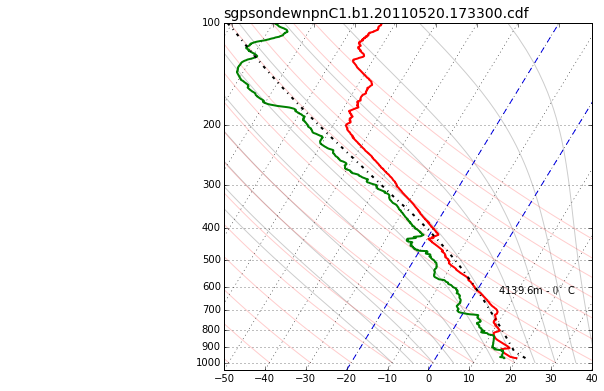

In [18]:
#plot_arm_skewt('/home/mvanlier/mvanlier/c1_soundings/sgpsondewnpnC1.b1.20110520.142700.cdf')
plot_arm_skewt('/home/mvanlier/mvanlier/c1_soundings/sgpsondewnpnC1.b1.20110520.173300.cdf')
#..